In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot

In [2]:
def read_trigger_efficiencies(root_file_path):
    with uproot.open(root_file_path) as root_file:
        efficiency_tree = root_file["trigger_efficiencies_tree"]
        
        m_values = efficiency_tree["M"].array()
        n_values = efficiency_tree["N"].array()
        efficiencies = efficiency_tree["Efficiency"].array()
        efficiency_errors = efficiency_tree["EfficiencyError"].array()
        energies = efficiency_tree["Energy"].array()
        sensor_sum = efficiency_tree["SumCounts"].array()
        thermal_electrons = efficiency_tree["ThermalElectrons"].array()
        
        return m_values, n_values, efficiencies, efficiency_errors, energies, sensor_sum, thermal_electrons

In [3]:
root_file_path = "/home/lane/Software/src/lumilar/system/analysis/data/trigger_efficiencies.root"
m_values, n_values, efficiencies, efficiency_errors, energies, sensor_sum, thermal_electrons = read_trigger_efficiencies(root_file_path)

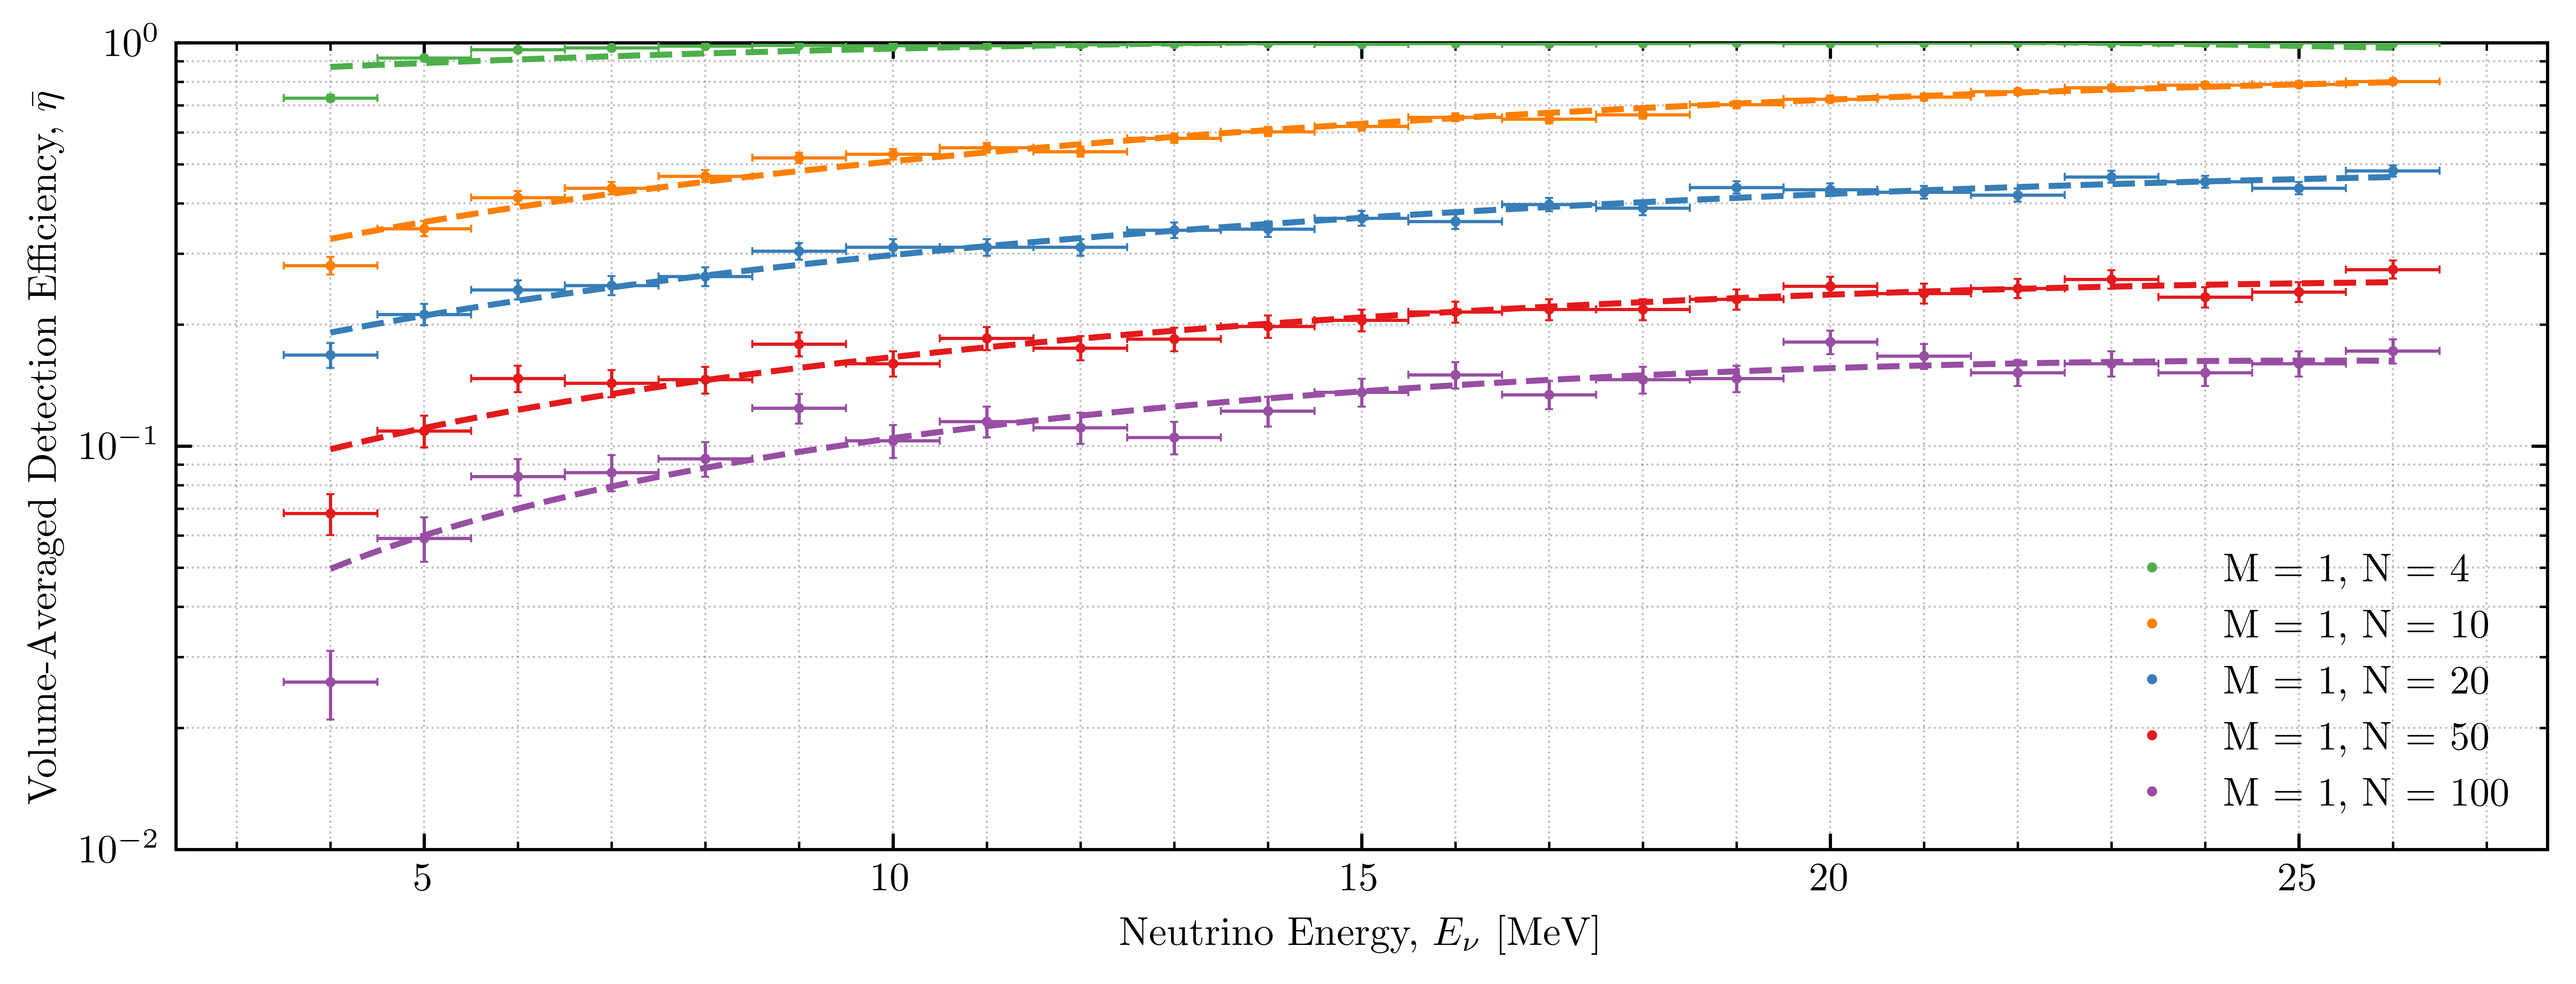

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# Use TeX-style font rendering
mpl.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
mpl.rc('text', usetex=True)

# Define the figure size
fig, ax = plt.subplots(figsize=(9, 3.5), dpi=800)

unique_combinations = set(zip(m_values, n_values))
colors = ['#E41A1C', '#377EB8', '#4DAF4A', '#FF7F00', '#984EA3', '#A65628', '#F781BF', '#999999']

color_mapping = {}
for i, comb in enumerate(unique_combinations):
    color_mapping[comb] = colors[i % len(colors)]

polynomials_dict = {}

degree = 2
for comb in unique_combinations:
    x_data = []
    y_data = []

    for i in range(len(energies)):
        if (m_values[i], n_values[i]) == comb:
            efficiency = efficiencies[i]
            if efficiency > 0.002:
                x_data.append(energies[i])
                y_data.append(efficiencies[i])

                color = color_mapping[comb]
                ax.errorbar(energies[i], efficiencies[i], yerr=efficiency_errors[i], xerr=1/2.0,
                            marker="o", markeredgewidth=0.5, capsize=1.0, markerfacecolor=color,
                            markeredgecolor=color, ms=2, color=color, lw=0.0, elinewidth=0.8,
                            zorder=10)

    if len(x_data) > degree:  # Ensuring enough data points for the polynomial fit
        coefficients = np.polyfit(x_data, y_data, degree)
        polynomial = np.poly1d(coefficients)
        
        # Storing the polynomial function in the dictionary
        polynomials_dict[comb] = polynomial
        
        x_range = np.linspace(min(x_data), max(x_data), 500)
        y_values = polynomial(x_range)
        ax.plot(x_range, y_values, '--', color=color, label=f"Fit for M = {comb[0]}, N = {comb[1]}")

sorted_combinations = sorted(unique_combinations, key=lambda comb: comb[1])

# Creating legend handles with crosses
handles = []
for comb in sorted_combinations:
    color = color_mapping[comb]
    line = ax.errorbar([], [], yerr=0.1, fmt='o', color=color, 
                       markeredgewidth=0.5, capsize=1.0, markerfacecolor=color,
                       markeredgecolor=color, ms=2, lw=0.0, elinewidth=0)
    handles.append(line)

# Adding the legend
legend = ax.legend(handles=handles, labels=[f'M = {comb[0]}, N = {comb[1]}' for comb in sorted_combinations], loc='lower right', fontsize=10, frameon=False)

ax.set_xlabel(r"Neutrino Energy, $E_\nu$ [MeV]")
ax.set_ylabel(r"Volume-Averaged Detection Efficiency, $\bar{\eta}$")

ax.set_ylim(1e-2, 1)

# Tick style
ax.tick_params(which='both', direction='in', top=True, right=True, length=4)
ax.tick_params(which='minor', length=2)
ax.minorticks_on()

# Grid
ax.grid(which='both', linestyle=':', linewidth=0.5, color='gray', alpha=0.5)

ax.set_yscale('log')

plt.tight_layout()
plt.show()


In [5]:
m_value_example, n_value_example = 4, 10  # Replace with your desired m and n values
polynomial_func = polynomials_dict.get((m_value_example, n_value_example))
if polynomial_func:
    energy_value = 5  # Replace with your desired energy value
    efficiency_value = polynomial_func(energy_value)
    print(f"Efficiency at energy {energy_value} MeV: {efficiency_value}")
else:
    print(f"No polynomial function found for combination M = {m_value_example}, N = {n_value_example}")

No polynomial function found for combination M = 4, N = 10


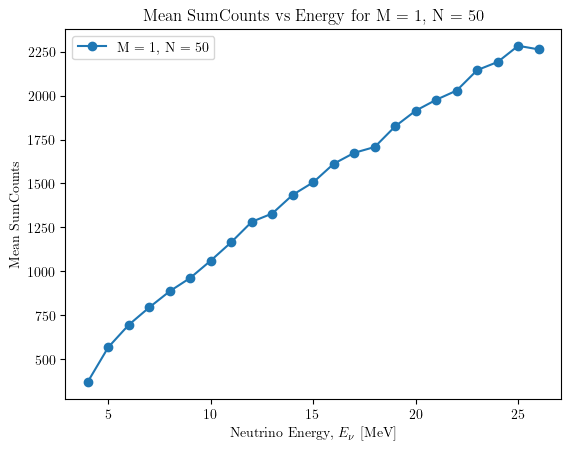

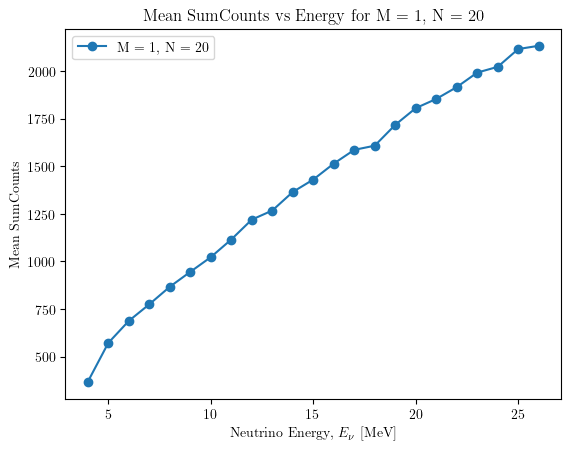

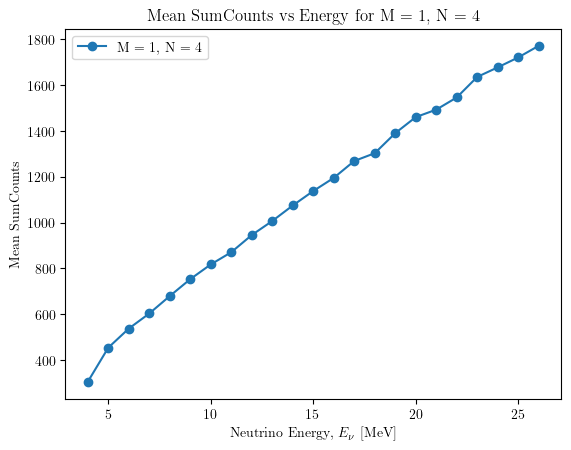

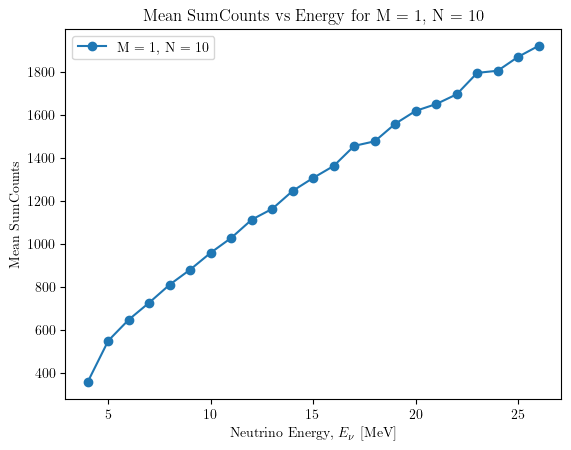

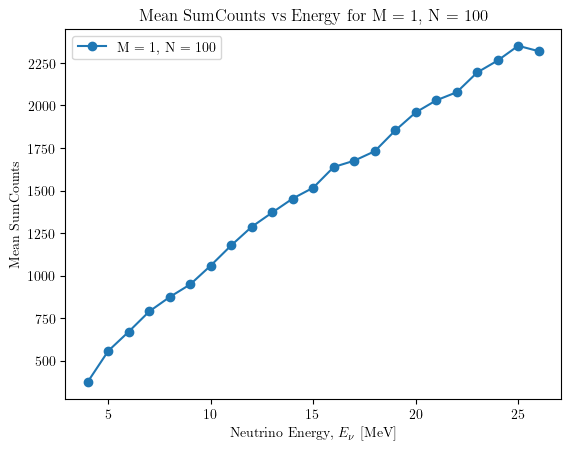

In [6]:
for comb in unique_combinations:
    plt.figure()
    x_data = []
    y_data_sum_counts = []

    for i in range(len(energies)):
        if (m_values[i], n_values[i]) == comb:
            x_data.append(energies[i])
            
            # Taking the mean of the internal array for this event
            mean_value = np.mean(sensor_sum[i])
            y_data_sum_counts.append(mean_value)
    
    plt.plot(x_data, y_data_sum_counts, 'o-', label=f"M = {comb[0]}, N = {comb[1]}")
    plt.xlabel(r"Neutrino Energy, $E_\nu$ [MeV]")
    plt.ylabel("Mean SumCounts")
    plt.title(f"Mean SumCounts vs Energy for M = {comb[0]}, N = {comb[1]}")
    plt.legend()
    plt.show()



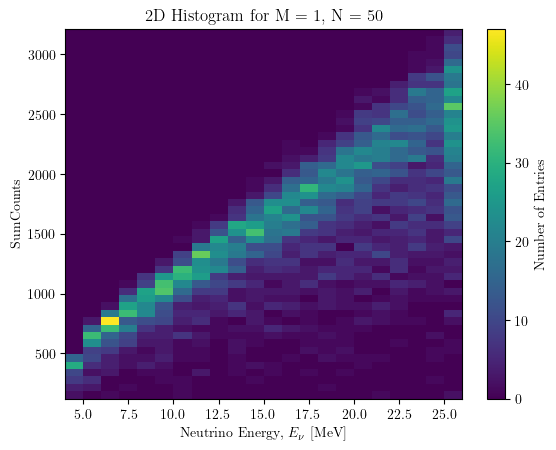

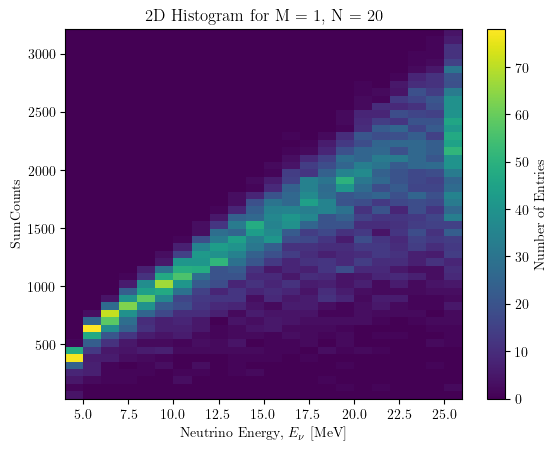

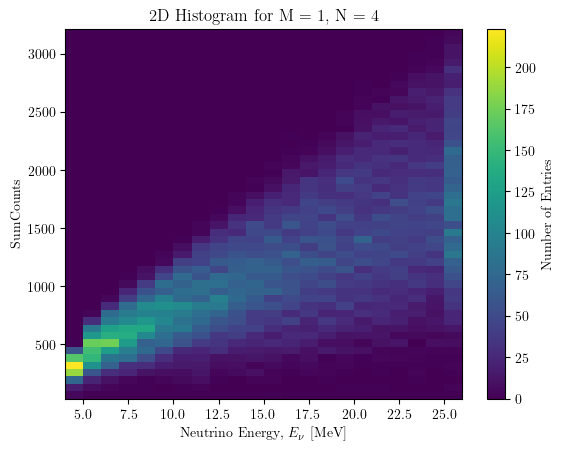

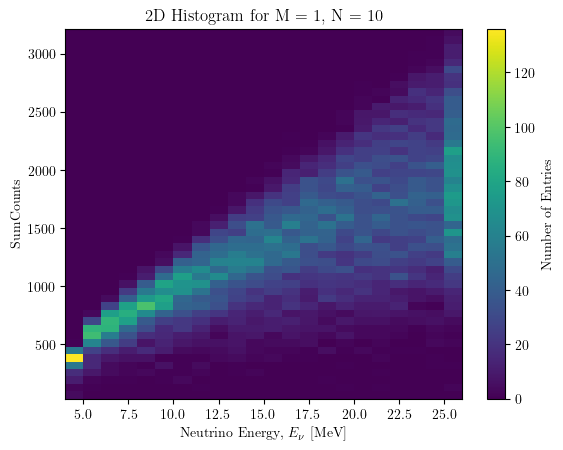

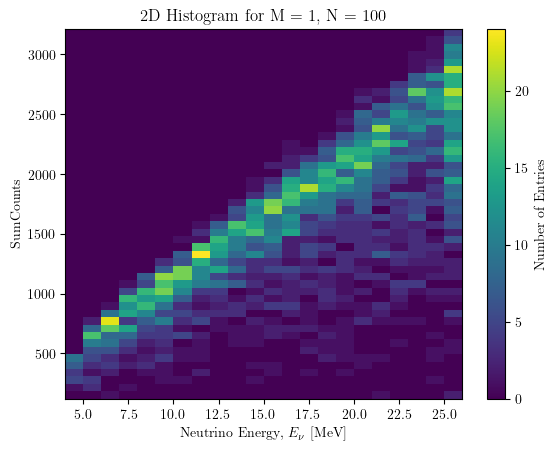

In [7]:
for comb in unique_combinations:
    plt.figure()
    x_data = []
    y_data_sum_counts = []

    for i in range(len(energies)):
        if (m_values[i], n_values[i]) == comb:
            x_data.extend([energies[i]] * len(sensor_sum[i]))  # Repeat the energy value for each sum count
            y_data_sum_counts.extend(sensor_sum[i])
    
    plt.hist2d(x_data, y_data_sum_counts, bins=[22, 50], cmap='viridis')
    plt.colorbar(label='Number of Entries')
    plt.xlabel(r"Neutrino Energy, $E_\nu$ [MeV]")
    plt.ylabel("SumCounts")
    plt.title(f"2D Histogram for M = {comb[0]}, N = {comb[1]}")
    plt.show()


/tmp/ipykernel_7821/1090883675.py:17: RuntimeWarning: invalid value encountered in true_divide
  K = nj_to_i / nj


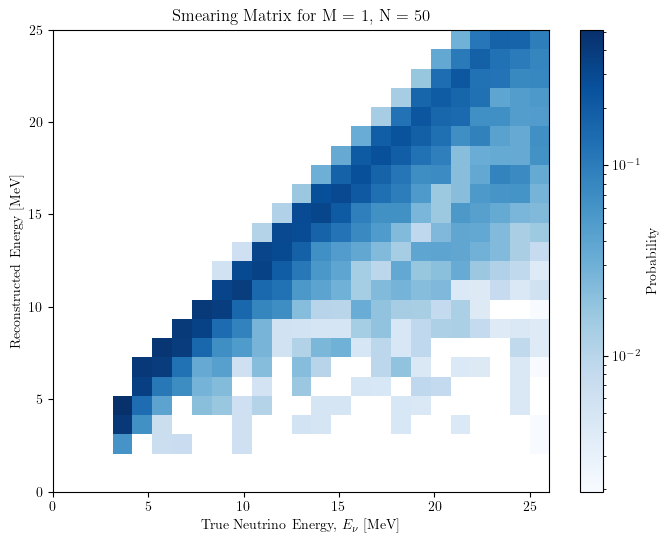

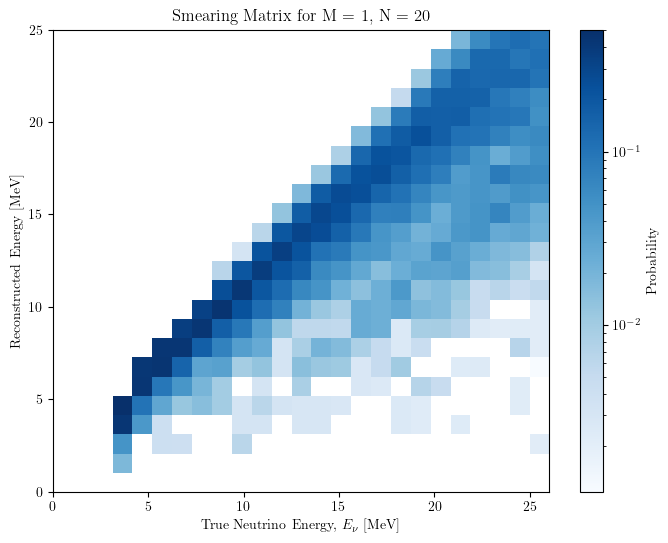

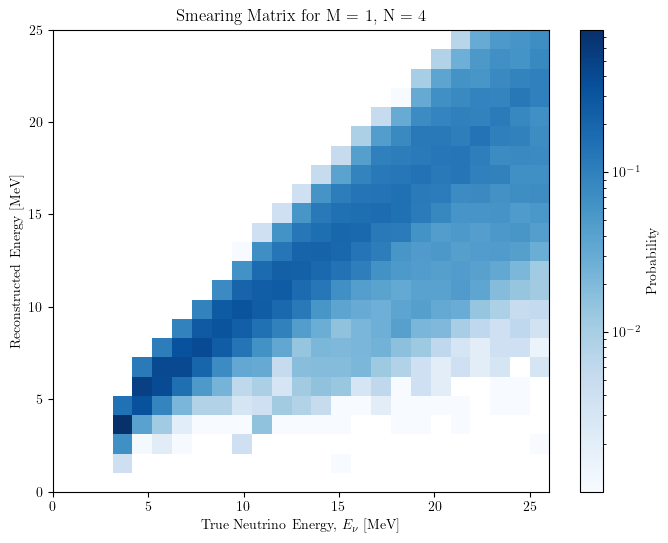

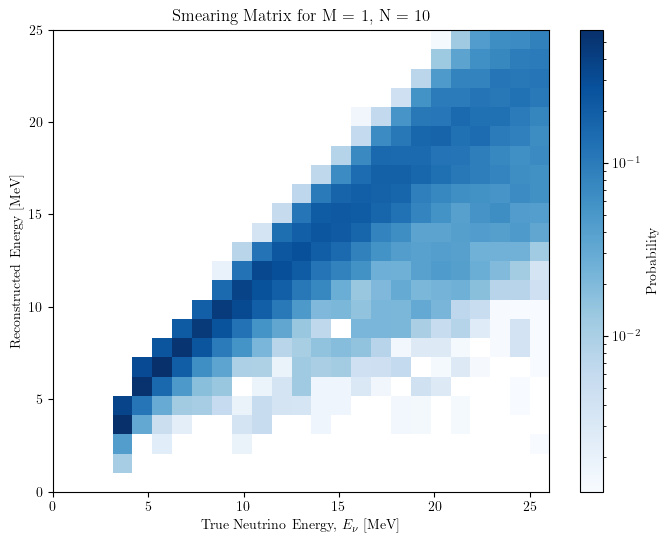

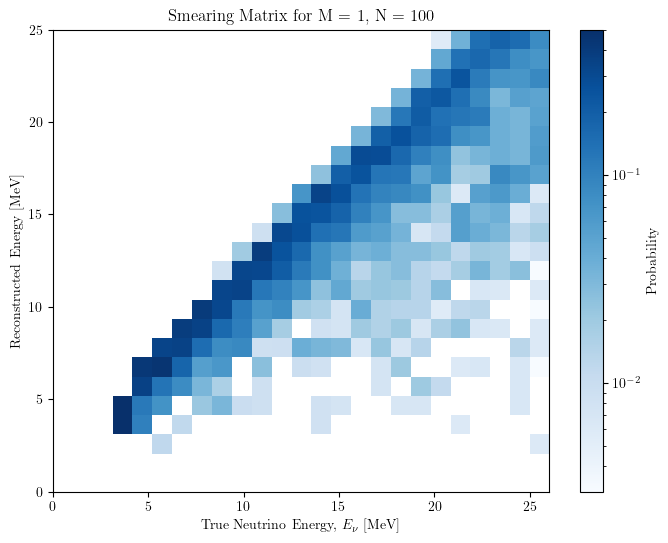

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def add_fluctuations(value):
    binomial_val = np.random.binomial(value, 0.7)
    poisson_val = np.random.poisson(binomial_val)

    return poisson_val

def compute_smearing_matrix(true_energies, reconstructed_energies, true_bin_edges, reco_bin_edges):
    # Histogram the true and reconstructed energies to get nj and nj->i
    nj, _ = np.histogram(true_energies, bins=true_bin_edges)
    nj_to_i, _, _ = np.histogram2d(reconstructed_energies, true_energies, bins=[reco_bin_edges, true_bin_edges])

    # Compute the smearing matrix Kij
    K = nj_to_i / nj

    return K

true_bin_edges = np.linspace(0, max(energies), int(max(energies)))  # Modify as required
reco_bin_edges = np.linspace(0, 25, 25)  # Modify as required

for comb in unique_combinations:
    x_data = []
    y_data_sum_counts = []
    y_data_reco = []

    for i in range(len(energies)):
        if (m_values[i], n_values[i]) == comb:
            x_data.extend([energies[i]] * len(thermal_electrons[i]))  
            y_data_sum_counts.extend(thermal_electrons[i])
            y_data_reco.extend((((add_fluctuations(thermal_electrons[i])/0.7)+(np.random.poisson(sensor_sum[i])/0.004))/50000)+1.504)  # Poisson smeared value

    # Compute the smearing matrix
    K = compute_smearing_matrix(x_data, y_data_reco, true_bin_edges, reco_bin_edges)
    
    # Plot the smearing matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(K, aspect='auto', cmap="Blues", origin='lower', 
               extent=[true_bin_edges[0], true_bin_edges[-1], reco_bin_edges[0], reco_bin_edges[-1]], norm=LogNorm())
    plt.colorbar(label='Probability')
    plt.xlabel(r"True Neutrino Energy, $E_\nu$ [MeV]")
    plt.ylabel(r"Reconstructed Energy [MeV]")
    plt.title(f"Smearing Matrix for M = {comb[0]}, N = {comb[1]}")
    plt.show()


/tmp/ipykernel_7821/2964625775.py:16: RuntimeWarning: divide by zero encountered in true_divide
  K = nj_to_i / nj[:, np.newaxis]  # Broadcasting to ensure division works correctly
/tmp/ipykernel_7821/2964625775.py:16: RuntimeWarning: invalid value encountered in true_divide
  K = nj_to_i / nj[:, np.newaxis]  # Broadcasting to ensure division works correctly


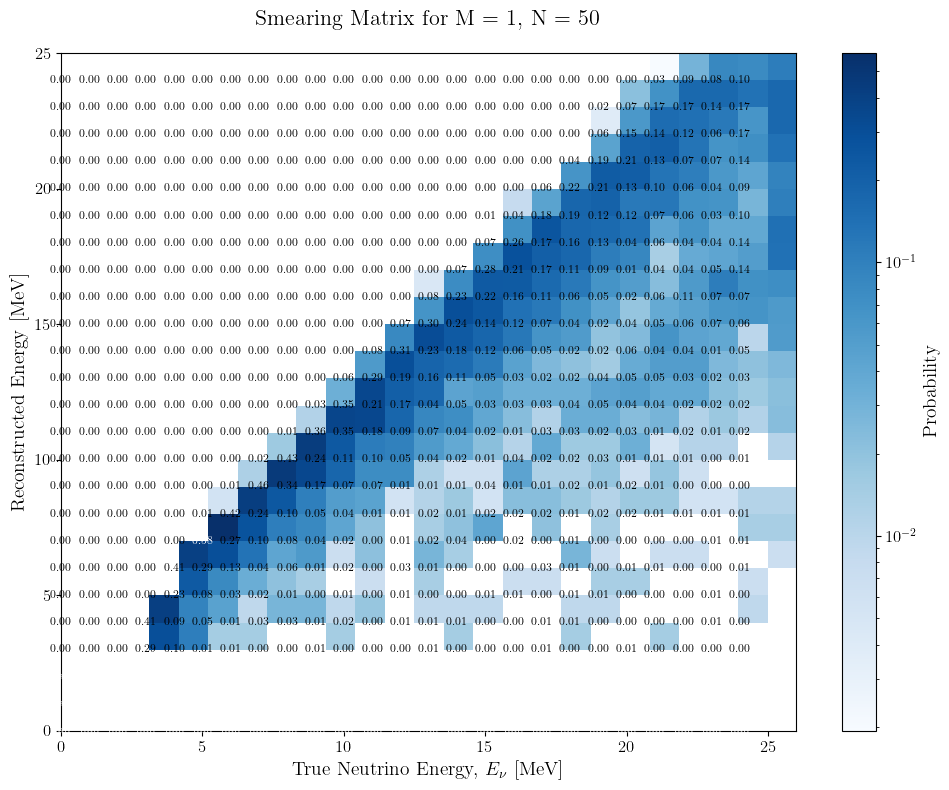

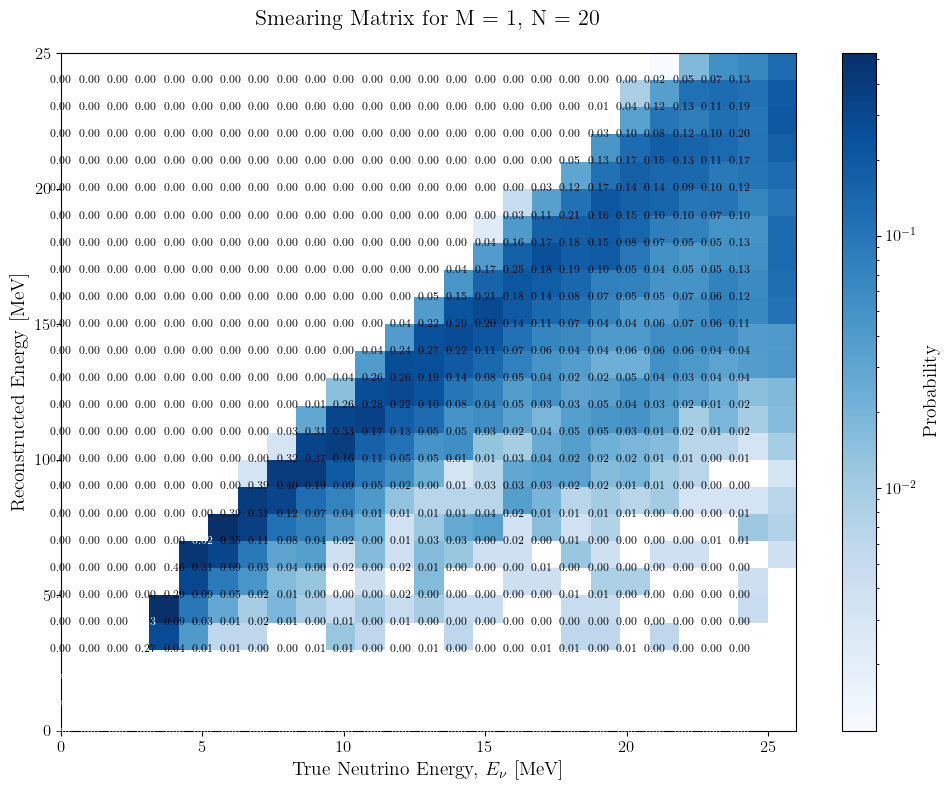

KeyboardInterrupt: 

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def add_fluctuations(value):
    binomial_val = np.random.binomial(value, 0.7)
    poisson_val = np.random.poisson(binomial_val)
    return poisson_val

def compute_smearing_matrix(true_energies, reconstructed_energies, true_bin_edges, reco_bin_edges):
    # Histogram the true and reconstructed energies to get nj and nj->i
    nj, _ = np.histogram(true_energies, bins=true_bin_edges)
    nj_to_i, _, _ = np.histogram2d(reconstructed_energies, true_energies, bins=[reco_bin_edges, true_bin_edges])
    
    # Compute the smearing matrix Kij
    K = nj_to_i / nj[:, np.newaxis]  # Broadcasting to ensure division works correctly
    
    return K

true_bin_edges = np.linspace(0, max(energies), int(max(energies)))
reco_bin_edges = np.linspace(0, 25, 26)  # This gives 25 bins

for comb in unique_combinations:
    x_data = []
    y_data_sum_counts = []
    y_data_reco = []

    for i in range(len(energies)):
        if (m_values[i], n_values[i]) == comb:
            x_data.extend([energies[i]] * len(thermal_electrons[i]))
            y_data_sum_counts.extend(thermal_electrons[i])
            y_data_reco.extend((((add_fluctuations(thermal_electrons[i])/0.7)+(np.random.poisson(sensor_sum[i])/0.004))/51000)+1.504)
    
    # Compute the smearing matrix
    K = compute_smearing_matrix(x_data, y_data_reco, true_bin_edges, reco_bin_edges)
    
    # Plot the smearing matrix
    fig, ax = plt.subplots(figsize=(10, 8))
    cax = ax.imshow(K, aspect='auto', cmap="Blues", origin='lower', 
                    extent=[true_bin_edges[0], true_bin_edges[-1], reco_bin_edges[0], reco_bin_edges[-1]], norm=LogNorm())
    
    # Adding probability values to the squares
    for i in range(len(reco_bin_edges)-1):
        for j in range(len(true_bin_edges)-1):
            text = ax.text(j, i, f"{K[i, j]:.2f}", ha="center", va="center", color="black" if K[i, j] < 0.5 else "white", fontsize=8)
    
    cbar = fig.colorbar(cax, ax=ax)
    cbar.set_label('Probability', size=14)
    cbar.ax.tick_params(labelsize=12)
    
    ax.set_xlabel(r"True Neutrino Energy, $E_\nu$ [MeV]", fontsize=14)
    ax.set_ylabel(r"Reconstructed Energy [MeV]", fontsize=14)
    ax.set_title(f"Smearing Matrix for M = {comb[0]}, N = {comb[1]}", pad=20, fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def add_fluctuations(value):
    binomial_val = np.random.binomial(value, 0.7)
    poisson_val = np.random.poisson(binomial_val)
    return poisson_val

def compute_smearing_matrix(true_energies, reconstructed_energies, true_bin_edges, reco_bin_edges):
    nj, _ = np.histogram(true_energies, bins=true_bin_edges)
    nj_to_i, _, _ = np.histogram2d(reconstructed_energies, true_energies, bins=[reco_bin_edges, true_bin_edges])
    
    # Compute the smearing matrix Kij, replace NaN values with zero
    with np.errstate(divide='ignore', invalid='ignore'):
        K = np.nan_to_num(nj_to_i / nj[:, np.newaxis])
    
    return K


true_bin_edges = np.linspace(0, max(energies), int(max(energies)))
reco_bin_edges = np.linspace(0, 25, 26)  # This gives 25 bins

for comb in unique_combinations:
    x_data = []
    y_data_sum_counts = []
    y_data_reco = []

    for i in range(len(energies)):
        if (m_values[i], n_values[i]) == comb:
            x_data.extend([energies[i]] * len(thermal_electrons[i]))
            y_data_sum_counts.extend(thermal_electrons[i])
            y_data_reco.extend((((add_fluctuations(thermal_electrons[i])/0.7)+(np.random.poisson(sensor_sum[i])/0.004))/50000)+1.504)
    
    K = compute_smearing_matrix(x_data, y_data_reco, true_bin_edges, reco_bin_edges)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    cax = ax.imshow(K, aspect='auto', cmap="plasma", origin='lower', 
                    extent=[true_bin_edges[0], true_bin_edges[-1], reco_bin_edges[0], reco_bin_edges[-1]], norm=LogNorm())
    
    # Calculate bin centers for placing text
    true_centers = (true_bin_edges[:-1] + true_bin_edges[1:]) / 2
    reco_centers = (reco_bin_edges[:-1] + reco_bin_edges[1:]) / 2

    for i, rc in enumerate(reco_centers):
        for j, tc in enumerate(true_centers):
            text = ax.text(tc, rc, f"{K[i, j]:.2f}", ha="center", va="center", color="black" if K[i, j] < 0.5 else "white", fontsize=8)
    
    cbar = fig.colorbar(cax, ax=ax)
    cbar.set_label('Probability', size=14)
    cbar.ax.tick_params(labelsize=12)
    
    ax.set_xlabel(r"True Neutrino Energy, $E_\nu$ [MeV]", fontsize=14)
    ax.set_ylabel(r"Reconstructed Energy [MeV]", fontsize=14)
    ax.set_title(f"Smearing Matrix for M = {comb[0]}, N = {comb[1]}", pad=20, fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    plt.tight_layout()
    plt.show()


/usr/lib/python3/dist-packages/numpy/ma/core.py:6849: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
/tmp/ipykernel_7126/3660279983.py:58: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
/usr/lib/python3/dist-packages/matplotlib/image.py:446: RuntimeWarning: overflow encountered in double_scalars
  newmin = vmid - dv * fact
/usr/lib/python3/dist-packages/matplotlib/image.py:451: RuntimeWarning: overflow encountered in double_scalars
  newmax = vmid + dv * fact
/usr/lib/python3/dist-packages/matplotlib/image.py:503: RuntimeWarning: invalid value encountered in multiply
  A_resampled *= ((a_max - a_min) / frac)
/usr/lib/python3/dist-packages/matplotlib/image.py:504: RuntimeWarning: invalid value encountered in multiply
  vrange *= ((a_max - a_min) / frac)


ValueError: Invalid vmin or vmax

<Figure size 1000x800 with 2 Axes>

ValueError: Invalid vmin or vmax

<Figure size 1000x800 with 2 Axes>

ValueError: Invalid vmin or vmax

<Figure size 1000x800 with 2 Axes>

ValueError: Invalid vmin or vmax

<Figure size 1000x800 with 2 Axes>

ValueError: Invalid vmin or vmax

<Figure size 1000x800 with 2 Axes>

/usr/lib/python3/dist-packages/numpy/ma/core.py:6849: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
/tmp/ipykernel_7126/4085246659.py:54: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
/usr/lib/python3/dist-packages/matplotlib/image.py:446: RuntimeWarning: overflow encountered in double_scalars
  newmin = vmid - dv * fact
/usr/lib/python3/dist-packages/matplotlib/image.py:451: RuntimeWarning: overflow encountered in double_scalars
  newmax = vmid + dv * fact
/usr/lib/python3/dist-packages/matplotlib/image.py:503: RuntimeWarning: invalid value encountered in multiply
  A_resampled *= ((a_max - a_min) / frac)
/usr/lib/python3/dist-packages/matplotlib/image.py:504: RuntimeWarning: invalid value encountered in multiply
  vrange *= ((a_max - a_min) / frac)


ValueError: Invalid vmin or vmax

<Figure size 1000x800 with 2 Axes>

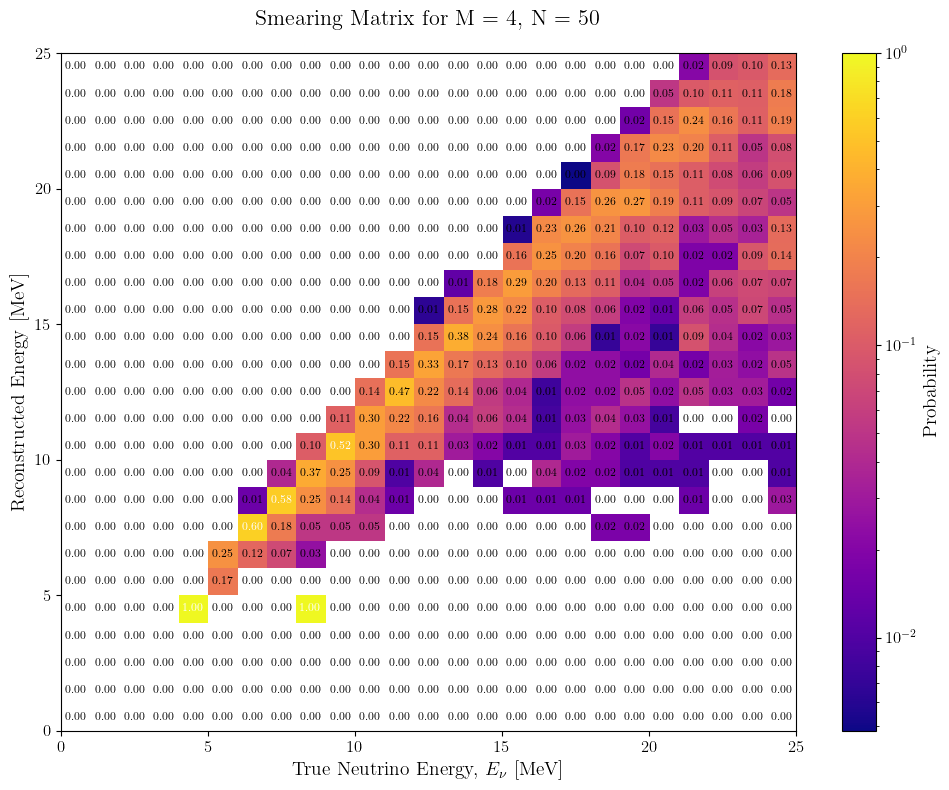

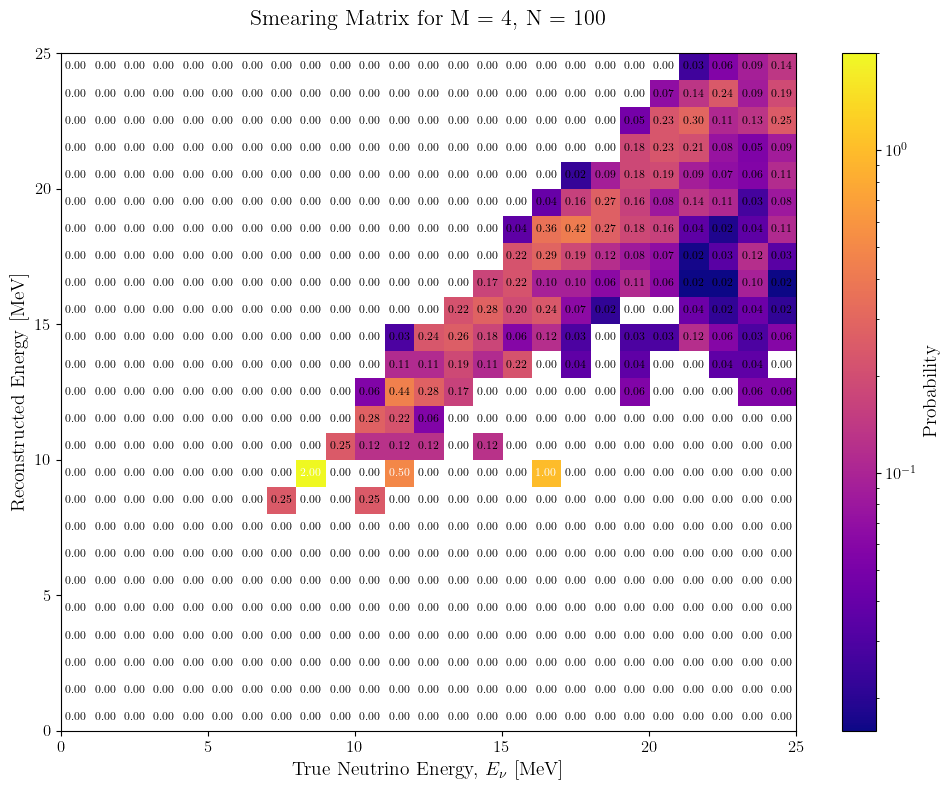

/usr/lib/python3/dist-packages/numpy/ma/core.py:6849: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
/tmp/ipykernel_7126/4085246659.py:54: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
/usr/lib/python3/dist-packages/matplotlib/image.py:446: RuntimeWarning: overflow encountered in double_scalars
  newmin = vmid - dv * fact
/usr/lib/python3/dist-packages/matplotlib/image.py:451: RuntimeWarning: overflow encountered in double_scalars
  newmax = vmid + dv * fact
/usr/lib/python3/dist-packages/matplotlib/image.py:503: RuntimeWarning: invalid value encountered in multiply
  A_resampled *= ((a_max - a_min) / frac)
/usr/lib/python3/dist-packages/matplotlib/image.py:504: RuntimeWarning: invalid value encountered in multiply
  vrange *= ((a_max - a_min) / frac)


ValueError: Invalid vmin or vmax

<Figure size 1000x800 with 2 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def add_fluctuations(value):
    binomial_val = np.random.binomial(value, 0.7)
    poisson_val = np.random.poisson(binomial_val)
    return poisson_val

def compute_smearing_matrix(true_energies, reconstructed_energies, true_bin_edges, reco_bin_edges):
    nj, _ = np.histogram(true_energies, bins=true_bin_edges)
    nj_to_i, _, _ = np.histogram2d(reconstructed_energies, true_energies, bins=[reco_bin_edges, true_bin_edges])
    
    with np.errstate(divide='ignore', invalid='ignore'):
        K = np.nan_to_num(nj_to_i / nj[:, np.newaxis])
    
    return K

true_bin_edges = np.linspace(0, 25, 26)  # 25 bins, hence 26 edges
reco_bin_edges = np.linspace(0, 25, 26)

for comb in unique_combinations:
    x_data = []
    y_data_reco = []

    for i in range(len(energies)):
        if (m_values[i], n_values[i]) == comb:
            x_data.extend([energies[i]] * len(thermal_electrons[i]))
            y_data_reco.extend((((add_fluctuations(thermal_electrons[i])/0.7)+(np.random.poisson(sensor_sum[i])/0.004))/50000)+1.504)
    
    K = compute_smearing_matrix(x_data, y_data_reco, true_bin_edges, reco_bin_edges)

    fig, ax = plt.subplots(figsize=(10, 8))
    cax = ax.imshow(K, aspect='auto', cmap="plasma", origin='lower', 
                    extent=[true_bin_edges[0], true_bin_edges[-1], reco_bin_edges[0], reco_bin_edges[-1]], norm=LogNorm())
    
    # Calculate bin centers for placing text
    true_centers = (true_bin_edges[:-1] + true_bin_edges[1:]) / 2
    reco_centers = (reco_bin_edges[:-1] + reco_bin_edges[1:]) / 2

    for i, rc in enumerate(reco_centers):
        for j, tc in enumerate(true_centers):
            text = ax.text(tc, rc, f"{K[i, j]:.2f}", ha="center", va="center", color="black" if K[i, j] < 0.5 else "white", fontsize=8)
    
    cbar = fig.colorbar(cax, ax=ax)
    cbar.set_label('Probability', size=14)
    cbar.ax.tick_params(labelsize=12)
    
    ax.set_xlabel(r"True Neutrino Energy, $E_\nu$ [MeV]", fontsize=14)
    ax.set_ylabel(r"Reconstructed Energy [MeV]", fontsize=14)
    ax.set_title(f"Smearing Matrix for M = {comb[0]}, N = {comb[1]}", pad=20, fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    plt.tight_layout()
    plt.show()


/usr/lib/python3/dist-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


Column sums for M = 4, N = 10: [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
             inf 1.79769313e+308 1.79769313e+308 9.75757427e-001
 9.77509440e-001 1.01801026e+000 1.79769313e+308 1.79769313e+308
 9.85179057e-001 1.05686922e+000 1.04215289e+000 1.04765660e+000
 1.07243468e+000 1.03323123e+000 1.79769313e+308 1.12307959e+000
 1.12504524e+000 1.06717963e+000 1.06709921e+000 1.03174632e+000
 1.88651781e+000]


/usr/lib/python3/dist-packages/numpy/ma/core.py:6849: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
/tmp/ipykernel_7126/2838186303.py:58: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
/usr/lib/python3/dist-packages/matplotlib/image.py:446: RuntimeWarning: overflow encountered in double_scalars
  newmin = vmid - dv * fact
/usr/lib/python3/dist-packages/matplotlib/image.py:451: RuntimeWarning: overflow encountered in double_scalars
  newmax = vmid + dv * fact
/usr/lib/python3/dist-packages/matplotlib/image.py:503: RuntimeWarning: invalid value encountered in multiply
  A_resampled *= ((a_max - a_min) / frac)
/usr/lib/python3/dist-packages/matplotlib/image.py:504: RuntimeWarning: invalid value encountered in multiply
  vrange *= ((a_max - a_min) / frac)


ValueError: Invalid vmin or vmax

<Figure size 1000x800 with 2 Axes>

Column sums for M = 4, N = 50: [0.         0.         0.         0.         1.         0.35833333
 0.76140351 0.86953576 1.78730539 1.05972997 0.93262953 0.98051284
 1.02788119 0.92678561 0.98200189 1.03832559 1.0433692  1.02835435
 1.05454707 1.02134116 1.1511684  1.08429938 0.93282686 0.86297433
 1.25249868]


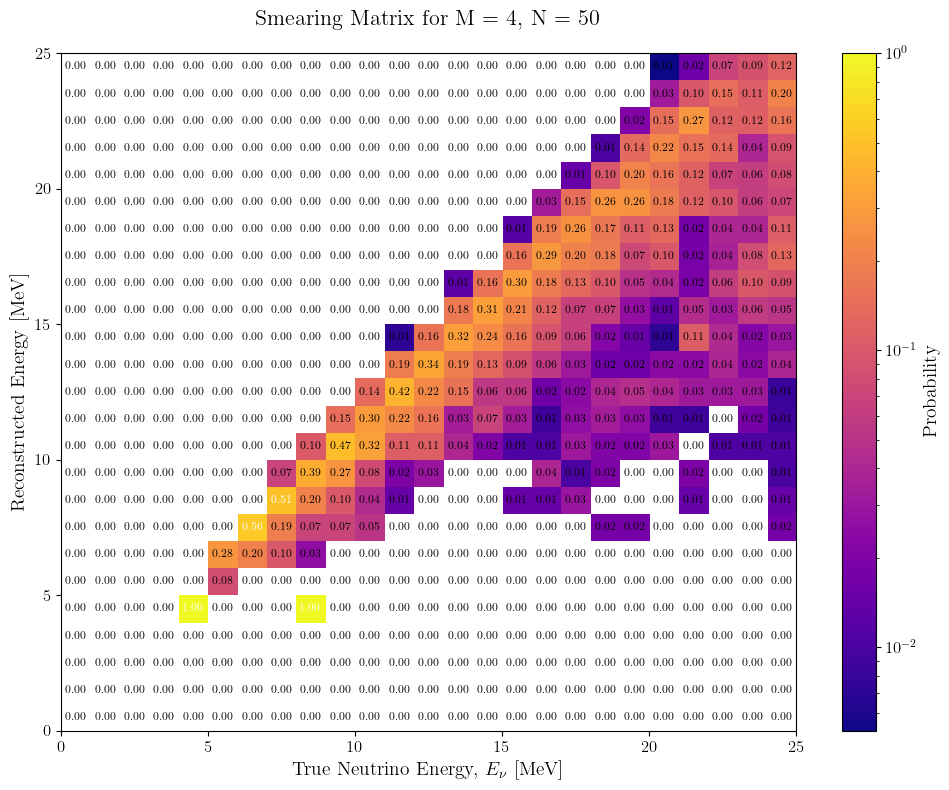

Column sums for M = 4, N = 100: [0.         0.         0.         0.         0.         0.
 0.         0.25       2.         0.25       0.70833333 1.50925926
 0.81558445 0.84655408 0.85541584 0.95423357 1.90087388 1.02967437
 0.82960553 1.08211474 1.11896526 1.11872505 0.85940561 0.88319124
 1.16970073]


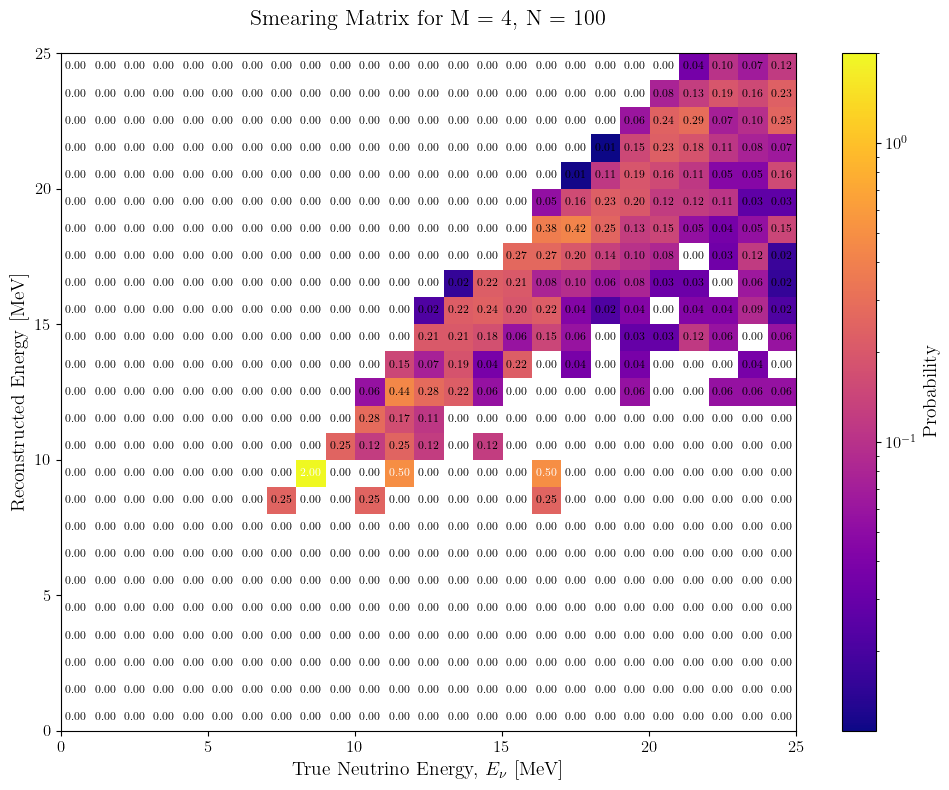

Column sums for M = 4, N = 20: [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 1.79769313e+308 9.14203620e-001 9.46090929e-001 9.87457474e-001
 9.58627763e-001 1.02205561e+000 9.78260885e-001 1.79769313e+308
 9.96823961e-001 1.02419977e+000 9.90089769e-001 1.05088109e+000
 1.02986173e+000 1.08647823e+000 1.79769313e+308 1.12967806e+000
 1.10059442e+000 1.04873484e+000 9.76242827e-001 9.60202438e-001
 1.52204507e+000]


/tmp/ipykernel_7126/2838186303.py:58: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
/usr/lib/python3/dist-packages/matplotlib/image.py:446: RuntimeWarning: overflow encountered in double_scalars
  newmin = vmid - dv * fact
/usr/lib/python3/dist-packages/matplotlib/image.py:451: RuntimeWarning: overflow encountered in double_scalars
  newmax = vmid + dv * fact
/usr/lib/python3/dist-packages/matplotlib/image.py:503: RuntimeWarning: invalid value encountered in multiply
  A_resampled *= ((a_max - a_min) / frac)
/usr/lib/python3/dist-packages/matplotlib/image.py:504: RuntimeWarning: invalid value encountered in multiply
  vrange *= ((a_max - a_min) / frac)


ValueError: Invalid vmin or vmax

<Figure size 1000x800 with 2 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def add_fluctuations(value):
    binomial_val = np.random.binomial(value, 0.7)
    poisson_val = np.random.poisson(binomial_val)
    return poisson_val

def compute_smearing_matrix(true_energies, reconstructed_energies, true_bin_edges, reco_bin_edges):
    nj, _ = np.histogram(true_energies, bins=true_bin_edges)
    nj_to_i, _, _ = np.histogram2d(reconstructed_energies, true_energies, bins=[reco_bin_edges, true_bin_edges])
    
    with np.errstate(divide='ignore', invalid='ignore'):
        K = np.nan_to_num(nj_to_i / nj[:, np.newaxis])
    
    return K

true_bin_edges = np.linspace(0, 25, 26)  # 25 bins, hence 26 edges
reco_bin_edges = np.linspace(0, 25, 26)

for comb in unique_combinations:
    x_data = []
    y_data_reco = []

    for i in range(len(energies)):
        if (m_values[i], n_values[i]) == comb:
            x_data.extend([energies[i]] * len(thermal_electrons[i]))
            y_data_reco.extend((((add_fluctuations(thermal_electrons[i])/0.7)+(np.random.poisson(sensor_sum[i])/0.004))/50000)+1.504)
    
    K = compute_smearing_matrix(x_data, y_data_reco, true_bin_edges, reco_bin_edges)
    
    # Check and print the sums of the columns of K
    column_sums = K.sum(axis=0)
    print(f"Column sums for M = {comb[0]}, N = {comb[1]}: {column_sums}")

    fig, ax = plt.subplots(figsize=(10, 8))
    cax = ax.imshow(K, aspect='auto', cmap="plasma", origin='lower', 
                    extent=[true_bin_edges[0], true_bin_edges[-1], reco_bin_edges[0], reco_bin_edges[-1]], norm=LogNorm())
    
    # Calculate bin centers for placing text
    true_centers = (true_bin_edges[:-1] + true_bin_edges[1:]) / 2
    reco_centers = (reco_bin_edges[:-1] + reco_bin_edges[1:]) / 2

    for i, rc in enumerate(reco_centers):
        for j, tc in enumerate(true_centers):
            text = ax.text(tc, rc, f"{K[i, j]:.2f}", ha="center", va="center", color="black" if K[i, j] < 0.5 else "white", fontsize=8)
    
    cbar = fig.colorbar(cax, ax=ax)
    cbar.set_label('Probability', size=14)
    cbar.ax.tick_params(labelsize=12)
    
    ax.set_xlabel(r"True Neutrino Energy, $E_\nu$ [MeV]", fontsize=14)
    ax.set_ylabel(r"Reconstructed Energy [MeV]", fontsize=14)
    ax.set_title(f"Smearing Matrix for M = {comb[0]}, N = {comb[1]}", pad=20, fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    plt.tight_layout()
    plt.show()
